# Heatwave Timeseries

Establish Eastern United States Heatwave Timeseries by:
1. Defining meteorological eastern US by clustering based on temperature anomalies
2. Taking spatial 95th percentile of temperature anomalies in eastern US cluster

following McKinnon et al. (2016)

In [1]:
# Add Project Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import GHCN, GHCNElement, Country
from heatwave import utils

import numpy as np
import pandas as pd

import netCDF4

from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.ndimage import binary_closing, binary_dilation
from scipy import interpolate

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import date
import calendar
import os

import shapefile
from shapely import geometry

DATA_ROOT = os.path.abspath("../../data")

In [2]:
# Utils

def summer_indices(datetimeindex):
    summer_series = []
    for year in np.unique(datetimeindex.index.year):        
        if calendar.isleap(year):
            summer_series.append(datetimeindex.loc[f"23-06-{year}":f"21-08-{year}"])
        else:
            summer_series.append(datetimeindex.loc[f"24-06-{year}":f"22-08-{year}"])    
    return pd.concat(summer_series)

def summer_indices_extended(datetimeindex):
    summer_series = []
    for year in np.unique(datetimeindex.index.year):        
        summer_series.append(datetimeindex.loc[f"{year}-06-20":f"{year}-08-25"])  
    return pd.concat(summer_series)

def plot_earth(view="EARTH"):
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [25, 10]

    # create Projection and Map Elements
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.OCEAN, color="white")
    ax.add_feature(cfeature.LAND, color="lightgray")

    if view == "US":
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
    elif view == "EAST US":
        ax.set_xlim(-105, -65)
        ax.set_ylim(25, 50)
    elif view == "EARTH":
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
    
    return projection

def plot_T95(T95, year):
    T95_std = T95.mean() + T95.std()

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot T95
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(T95[year], c="black", label="T95")
    plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")

    plt.ylabel("T95 (°C)")
    plt.xlabel("Date")
    plt.ylim(-2, 12)
    plt.legend()
    plt.show()
    
def strip_zeros(data):
    stripped_data = data.astype(np.float32)
    stripped_data[data == 0] = np.NaN
    return stripped_data

### Load netCDF4 Land Temperature Data

In [69]:
dataset = "ERA"
# dataset = "NCEP-NCAR"

if dataset == "ERA":
    TARGET = os.path.join(DATA_ROOT, "ERA/t2m_1979-2017_1_12_daily_0.75deg.nc")
    TARGET_VAR = 't2m'
    TARGET_TIME_UNIT = 'h'
    TARGET_TIME_ORIGIN = '1900-01-01'
    LANDSEAMASK = os.path.join(DATA_ROOT, "ERA/landseamask_0.75deg.nc")
    LANDSEAMASK_VAR = 'lsm'
elif dataset == "NCEP-NCAR":
    TARGET = os.path.join(DATA_ROOT, "NCEP-NCAR/air.sig995.tmax.nc")
    TARGET_VAR = 'tmax'
    LANDSEAMASK = os.path.join(DATA_ROOT, "NCEP-NCAR/land-sea-mask.nc")
    LANDSEAMASK_VAR = 'land'
    TARGET_TIME_UNIT = 'D'
    TARGET_TIME_ORIGIN = '1948-01-01'

t2m = netCDF4.Dataset(TARGET)
t2m_time = pd.DataFrame(index=pd.to_datetime(t2m['time'][:],
                                             unit=TARGET_TIME_UNIT,
                                             origin=TARGET_TIME_ORIGIN))

t2m_summer = summer_indices(t2m_time).index
t2m_summer_extended = summer_indices_extended(t2m_time).index

# TODO: Fix in a smarter, less memory-hungry way :)
t2m_data = t2m[TARGET_VAR][(t2m_summer - t2m_time.index[0]).days]
t2m_data_extended = t2m[TARGET_VAR][(t2m_summer_extended - t2m_time.index[0]).days]

t2m_lats = t2m['latitude'][:]
t2m_lons = t2m['longitude'][:]

### Create Country Mask

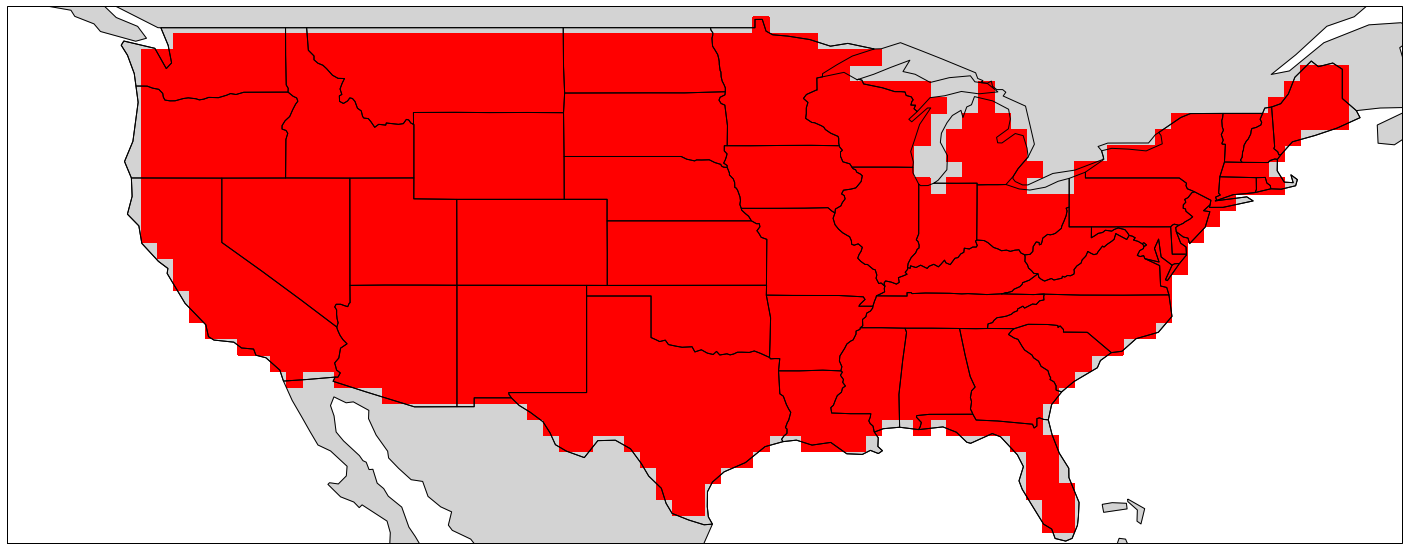

In [70]:
# Create Country Mask (Each Country get's its own index according to Countries Enumeration)
countries_mask = utils.era_country_mask(TARGET)
countries_mask = countries_mask.astype(np.float)
countries_mask[countries_mask == -1] = np.NaN

# Load ERA Land Sea Mask to mask away country mask inaccuracies
LSM  = netCDF4.Dataset(LANDSEAMASK)
landseamask = LSM[LANDSEAMASK_VAR][0].astype(np.bool)

# Obtain (Buffered, a.k.a. not calculated more times than needed) Country Mask
mask = utils.era_country_mask(TARGET) == Country.US

# US Mainland Bounding Box Mask (To rule out Hawai & Alaska)
grid = utils.era_coordinate_grid(TARGET)
us_mainland_mask = (grid[..., 0] > 230) * (grid[..., 0] < 295) * (grid[..., 1] > 24) * (grid[..., 1] < 50)

# Incorporate Land Area Lost due to rivers & lakes
mask_us = binary_closing(mask * us_mainland_mask)

# Mask out all ERA Interim Sea Grid Cells
mask_us *= landseamask

# Plot Final US Mask in a suitable red color
mask_plot = mask_us.astype(np.float)
mask_plot[mask_us == False] = np.NaN
projection = plot_earth("US")
plt.pcolormesh(t2m_lons, t2m_lats, mask_plot, transform=projection, cmap="autumn")
plt.show()

### Defining Eastern US by Clustering

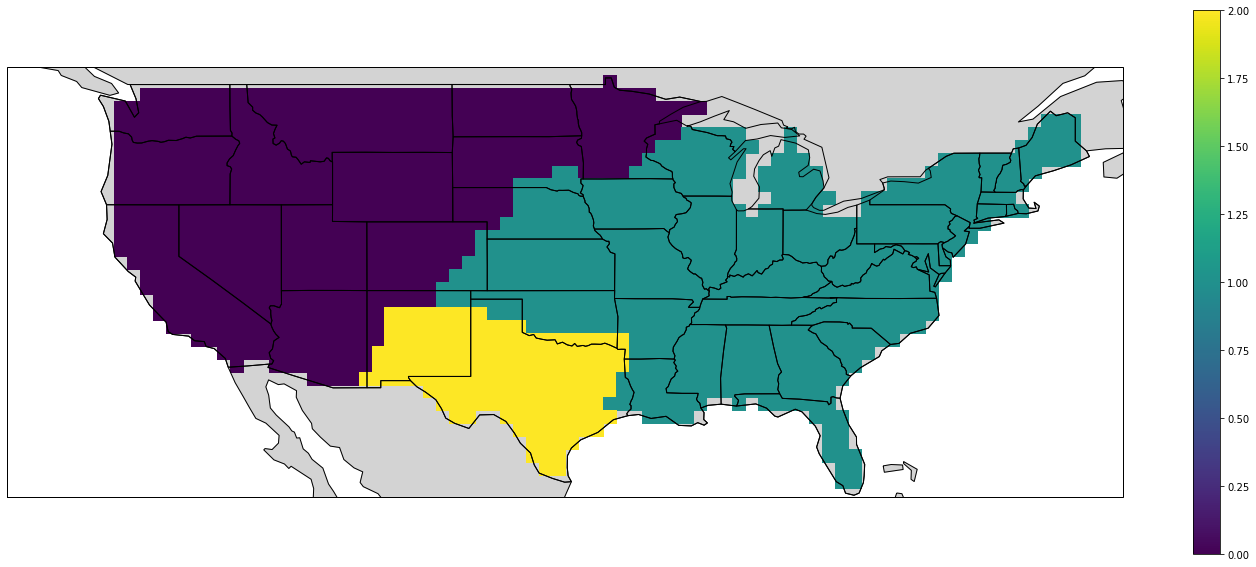

In [71]:
N = 3  # Number of Clusters

# Binary Heatwave Timeseries Clustering
t2m_us = t2m_data[:, mask_us]
T95_bool = t2m_us > np.quantile(t2m_us, 0.95, 0)

# cluster = KMeans(N)
# cluster = AgglomerativeClustering(N)
cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
cluster.fit(T95_bool.T)

# Obtain Cluster Labels
labels = np.empty(t2m_data.shape[1:], np.float32)
labels.fill(np.NaN)
labels[mask_us] = cluster.labels_

# Obtain East Cluster (by looking at longitude)
label_coordinate = [np.mean(grid[labels == i], 0) for i in range(N) if np.sum(labels == i) > 5]
label_longitude = [coordinate[0] for coordinate in label_coordinate]
label_east = label_longitude.index(max(label_longitude))

# Obtain Final Eastern US Mask
mask_east_us = labels == label_east

# Plot Clustering Result
projection = plot_earth("US")
plt.pcolormesh(t2m_lons, t2m_lats, labels, transform=projection)
plt.colorbar()
plt.show()

### Calculate T95 (Heatwave) Timeseries

T95


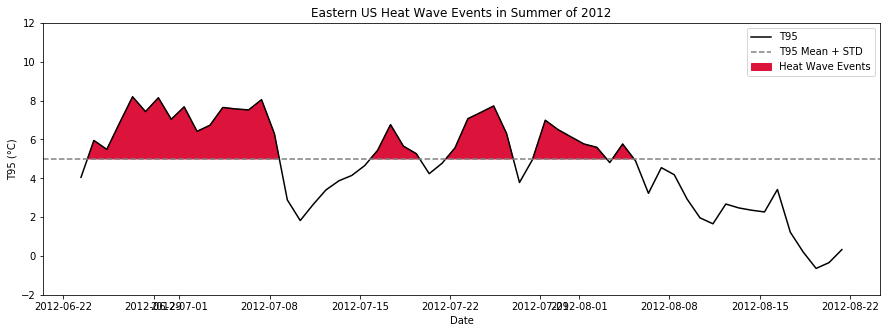

T95 Rolling Mean (7 Days)


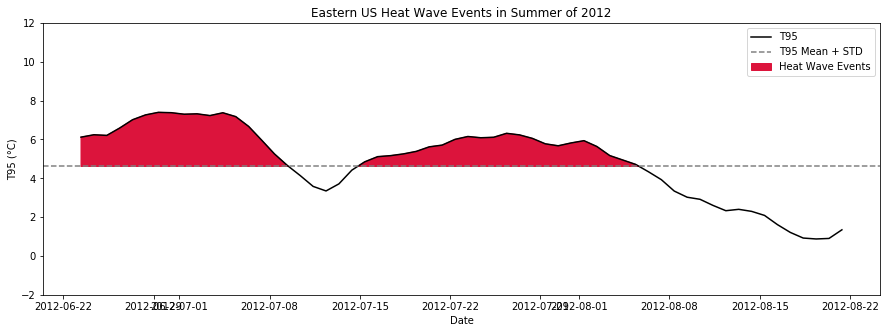

In [104]:
# Calculate Anomalies on (Extended) Summer Days
t2m_east_us = pd.DataFrame(t2m_data_extended[:, mask_east_us], index=t2m_summer_extended)
t2m_east_us_anomaly = t2m_east_us.groupby([t2m_east_us.index.month, t2m_east_us.index.day]).apply(lambda x: x - x.mean())

# Calculate Temperature Anomaly Spatial Quantile
T95 = t2m_east_us_anomaly.quantile(0.95, 1)

# Take 7 Day Rolling Mean
# (Since we're not nescessarily concerned with daily heatwaves, but more in weekly behaviour)
T95_mean = T95.rolling(7, center=True).mean()

# Limit Signals to Peak Summer
# There were extended before to allow for the Rolling Mean!
T95 = T95[t2m_summer]
T95_mean = T95_mean[t2m_summer]

# Export Daily Heatwave Signal for Peak Summer
T95.to_csv(os.path.join(DATA_ROOT, f'out/heatwave_{dataset}.csv'))

# Export 7 Day Rolling Mean Heatwave Signal for Peak Summer
T95_mean.to_csv(os.path.join(DATA_ROOT, f'out/heatwave_mean_{dataset}.csv'))

plot_year = "2012"
print("T95")
plot_T95(T95, plot_year)
print("T95 Rolling Mean (7 Days)")
plot_T95(T95_mean, plot_year)

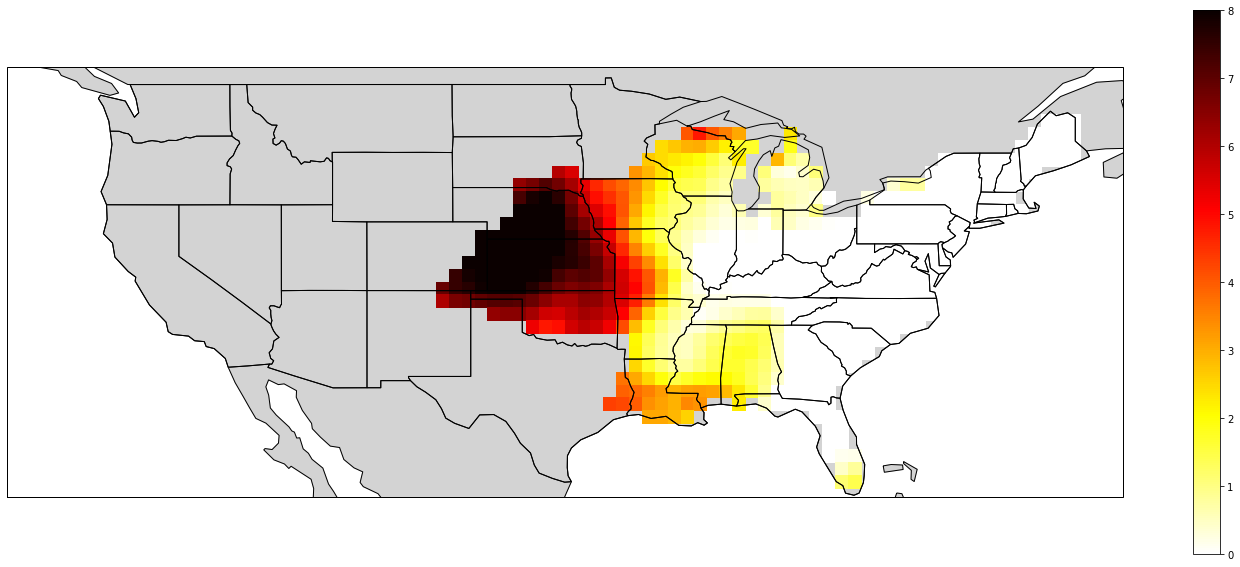

In [73]:
# Plot Temperature Anomalies on a specific hot summer day
t2m_east_anomaly_plot = np.empty(t2m_data.shape[1:], dtype=np.float32)
t2m_east_anomaly_plot.fill(np.NaN)
t2m_east_anomaly_plot[mask_east_us] = t2m_east_us_anomaly.loc["2012-06-27"].values.ravel()

projection = plot_earth("US")
plt.pcolormesh(t2m_lons, t2m_lats, t2m_east_anomaly_plot, cmap="hot_r", transform=projection, vmin=0, vmax=8)
plt.colorbar()
plt.show()

# NCEP/NCAR Heatwave Timeseries
### Create NCEP/NCAR Mask

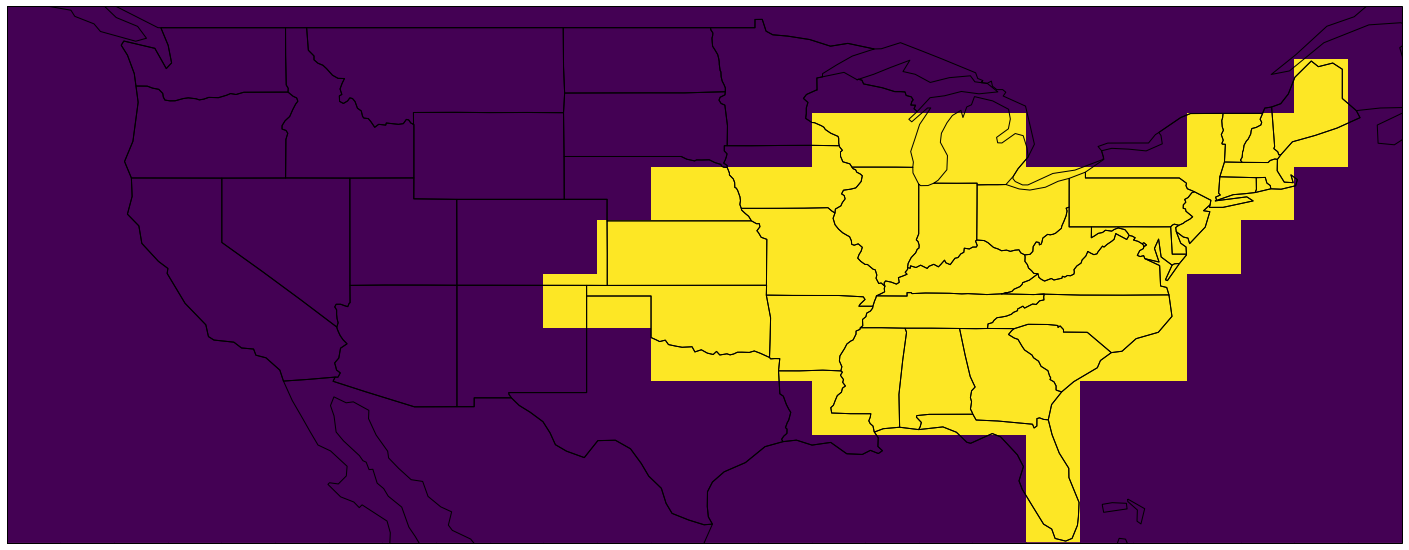

In [83]:
NCEP_NCAR_TARGET = os.path.join(DATA_ROOT, 'NCEP-NCAR/air.sig995.tmax.nc')
NCEP_NCAR = netCDF4.Dataset(NCEP_NCAR_TARGET)
NCEP_NCAR_LSM = netCDF4.Dataset(os.path.join(DATA_ROOT, 'NCEP-NCAR/land-sea-mask.nc'))['land'][0] == 1
NCEP_NCAR_GRID = utils.era_coordinate_grid(NCEP_NCAR_TARGET)
NCEP_NCAR_COORDS = NCEP_NCAR_GRID[NCEP_NCAR_LSM]

NCEP_NCAR_GRID_INTERP = interpolate.griddata(grid.reshape(-1, 2), mask_east_us.ravel(), NCEP_NCAR_COORDS.reshape(-1, 2), method='linear')

NCEP_NCAR_EAST_US_MASK = np.zeros(NCEP_NCAR_LSM.shape, np.bool)
NCEP_NCAR_EAST_US_MASK[NCEP_NCAR_LSM] = NCEP_NCAR_GRID_INTERP

plot_earth("US")
plt.pcolormesh(NCEP_NCAR['longitude'], NCEP_NCAR['latitude'], NCEP_NCAR_EAST_US_MASK)
plt.show()

### Create NCEP/NCAR Heatwave Timeseries

T95


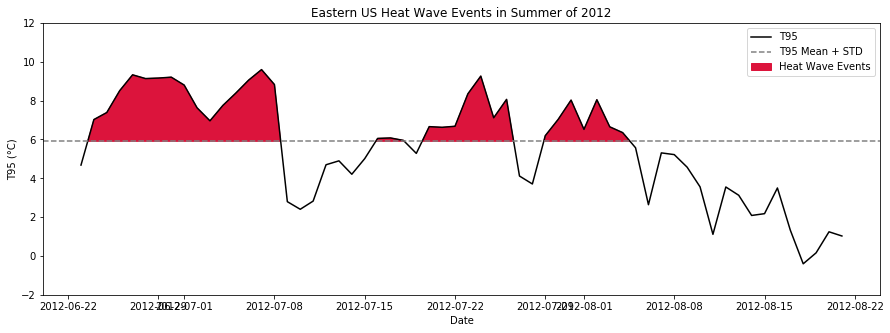

T95 Rolling Mean (7 Days)


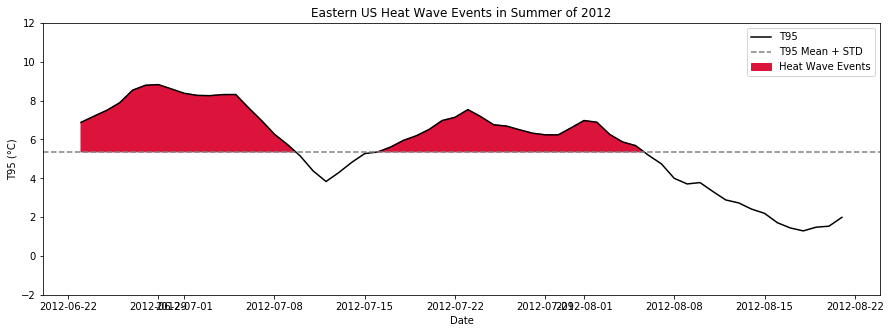

In [109]:
tmax_time = pd.DataFrame(index=pd.to_datetime(NCEP_NCAR['time'][:], unit='D', origin='1948-01-01'))

tmax_summer = summer_indices(tmax_time).index
tmax_summer_extended = summer_indices_extended(tmax_time).index

tmax = pd.DataFrame(data=NCEP_NCAR['tmax'][(tmax_summer_extended - tmax_time.index[0]).days][:, NCEP_NCAR_EAST_US_MASK], index=tmax_summer_extended)
tmax_anomaly = tmax.groupby([tmax.index.month, tmax.index.day]).apply(lambda x: x - x.mean())

NCEP_NCAR_T95 = tmax_anomaly.quantile(0.95, 1)
NCEP_NCAR_T95_mean = NCEP_NCAR_T95.rolling(7, center=True).mean()

NCEP_NCAR_T95 = NCEP_NCAR_T95[tmax_summer]
NCEP_NCAR_T95_mean = NCEP_NCAR_T95_mean[tmax_summer]

NCEP_NCAR_T95.to_csv(os.path.join(DATA_ROOT, f'out/heatwave_NCEP-NCAR.csv'))
NCEP_NCAR_T95_mean.to_csv(os.path.join(DATA_ROOT, f'out/heatwave_mean_NCEP-NCAR.csv'))

plot_year = "2012"
print("T95")
plot_T95(NCEP_NCAR_T95, plot_year)
print("T95 Rolling Mean (7 Days)")
plot_T95(NCEP_NCAR_T95_mean, plot_year)

# SPI Timeseries
### Load Precipation Data

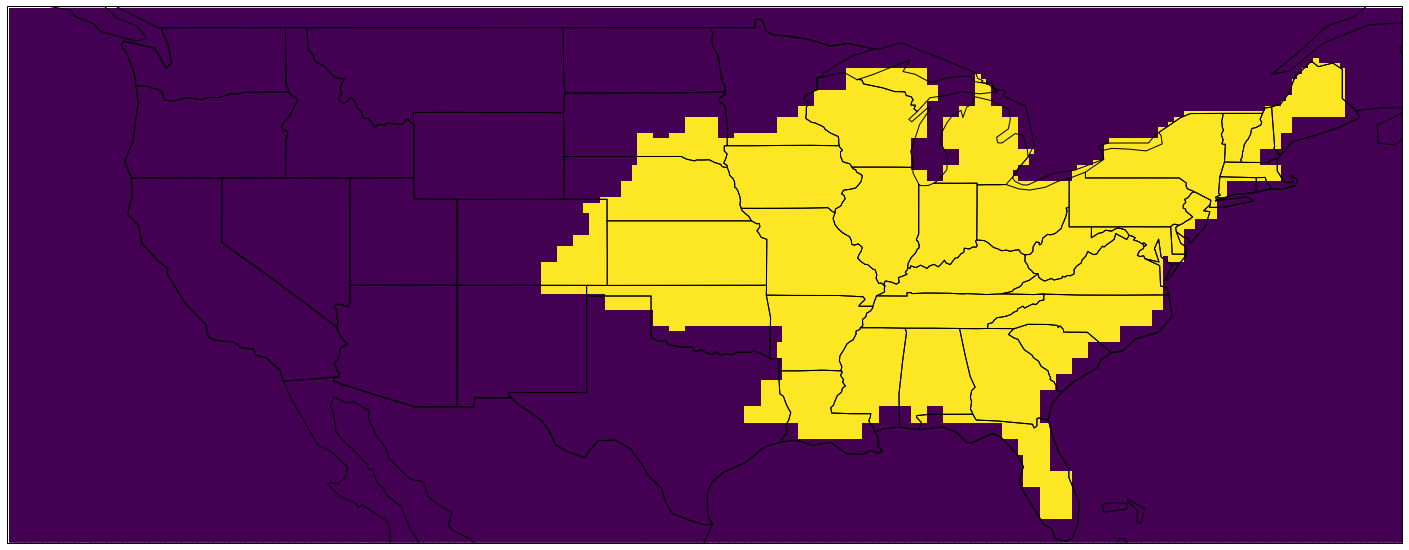

In [107]:
# Create Eastern US Mask for Precipation Data
PRCP_TARGET = os.path.join(DATA_ROOT, 'PSD/precip.V1.0.1979.nc')
PRCP = netCDF4.Dataset(PRCP_TARGET)
PRCP_LON = PRCP['lon'][:]
PRCP_LAT = PRCP['lat'][:]
PRCP_GRID = utils.era_coordinate_grid(PRCP_TARGET)

PRCP_SEA_MASK = np.isnan(PRCP['precip'][0]) == False

PRCP_GRID_COORDS = PRCP_GRID[PRCP_SEA_MASK]

PRCP_GRID_INTERP = interpolate.griddata(grid.reshape(-1, 2), mask_east_us.ravel(), PRCP_GRID_COORDS.reshape(-1, 2), method='nearest')

PRCP_EAST_US_MASK = np.zeros(PRCP_SEA_MASK.shape, np.bool)
PRCP_EAST_US_MASK[PRCP_SEA_MASK] = PRCP_GRID_INTERP

plot_earth("US")
plt.pcolormesh(PRCP_LON, PRCP_LAT, PRCP_EAST_US_MASK)
plt.show()

In [9]:
prcp_dfs = []

for file in sorted([f for f in os.listdir(os.path.join(DATA_ROOT, 'PSD')) if 'precip' in f]):
    dataset = netCDF4.Dataset(os.path.join(DATA_ROOT, 'PSD', file))
    time = pd.to_datetime(dataset['time'][:], unit='h', origin='1800-01-01')
    prcp_dfs.append(pd.DataFrame(dataset['precip'][:].reshape(len(time), -1), index=time))
    
prcp_df = pd.concat(prcp_dfs).loc[:, PRCP_EAST_US_MASK.ravel()]

In [10]:
# Calculate Rolling Sum and Normalize Precipation Data to get Standardized Precipitation Index

SPI_OUT = pd.DataFrame(index=prcp_df.index)
SPI_OUT.index.name = "date"

for integration in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    print(f"\rComputing Integration {integration}", end="")
    SPI = prcp_df.rolling(integration).sum()
    SPI = (SPI - SPI.mean(0)) / SPI.std(0)
    SPI_OUT[integration] = SPI.mean(1)

SPI_OUT.to_csv(os.path.join(DATA_ROOT, 'out/SPI.csv'))

Computing Integration 10

/Users/bram/miniconda3/lib/python3.6/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


Computing Integration 90

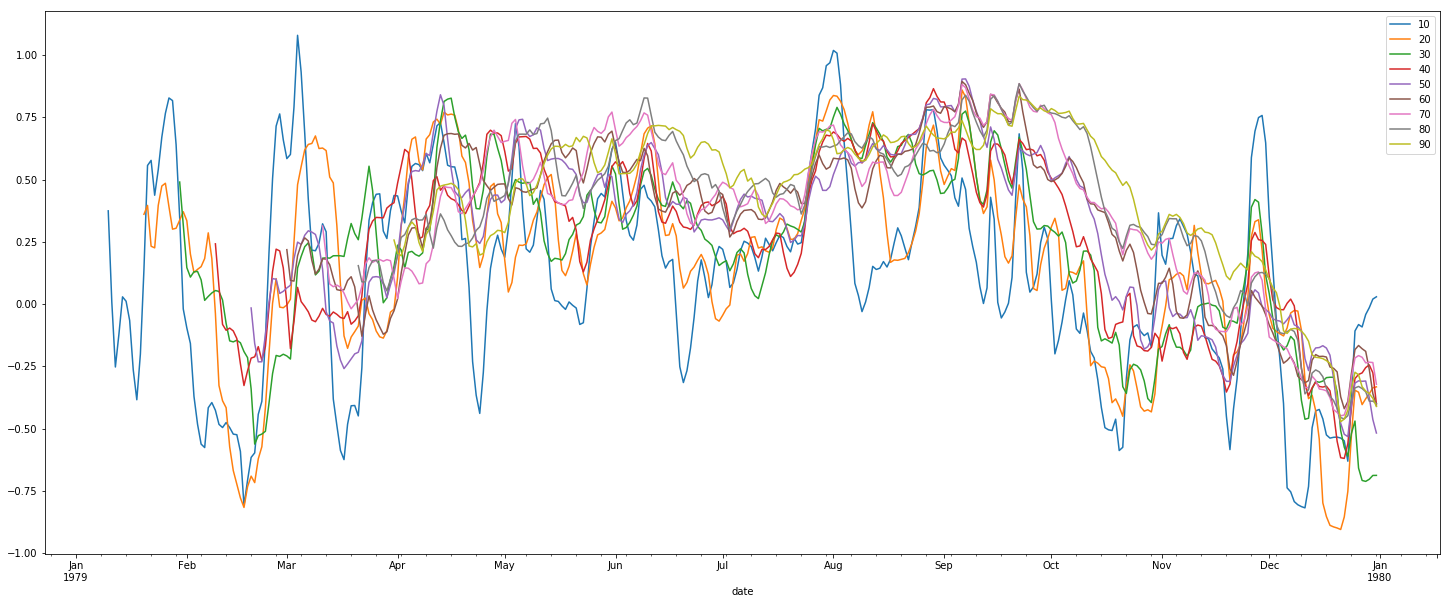

In [11]:
SPI_OUT["1979"].plot()